# 오늘 뭐먹지 

파이널 프로젝트: 점심 메뉴 추천 시스템    
**회사 주변 방문한 적이 있는 식당을 기반으로 아직 가보지 못한 식당들의 평점을 예측, 평점이 높은 식당들 중에서 랜덤으로 추천해주는 것이 파이널 프로젝트의 목표**

## 라이브러리 임포트 

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from bs4 import BeautifulSoup

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import time
print('Libraries imported.')

Libraries imported.


**머신러닝에 필요한 라이브러리는 추후에 임포트**

## 포스퀘어 API를 위한 아이디 저장 

In [2]:
CLIENT_ID = 'YMNNYPQZOJX4DRRLTUQ3L0WVFMWFYOTB10EKYKNJ2LFEXRKP' # your Foursquare ID
CLIENT_SECRET = 'QGDEG2QCFDXRDOE2Q1VXINOZG1P0T5RIKQB32USLXTA5ESEW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YMNNYPQZOJX4DRRLTUQ3L0WVFMWFYOTB10EKYKNJ2LFEXRKP
CLIENT_SECRET:QGDEG2QCFDXRDOE2Q1VXINOZG1P0T5RIKQB32USLXTA5ESEW


## 데이터 수집    
머신러닝을 위해 필요한 정보는 회사 근처의 식당 정보: 식당의 분류, 평점, 가격, 팁, 사진 등이 있음. 식당 목록은 포스퀘어 API를 통해 수집하고, 평점, 가격, 팁 등 디테일은 스크래핑을 통해 수집함 

### 회사 근처 지역의 위도/경도   
회사 인근 지하철역을 Location으로 지정함. 강남의 지하철 역은 주요 사거리마다 개통되어있기 때문 

In [3]:
df_points = pd.DataFrame({
    'Station':['Yeoksam','Gangnam','Sinnonhyeon','Yangjea'],
    'Latitude':[37.500705,37.497921,37.504435,37.484536],
    'Longitude':[127.036880,127.027675,127.024537,127.034036]
})
df_points

,Station,Latitude,Longitude
0,Yeoksam,37.500705,127.036880
1,Gangnam,37.497921,127.027675
2,Sinnonhyeon,37.504435,127.024537
3,Yangjea,37.484536,127.034036


### category type 확보 공식 

In [4]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### df_point를 기반으로 식당 목록 가져오기

In [5]:
col_names = ['name','categories','lat','lng','id','Station']
neighborhoods = pd.DataFrame(columns=col_names)
neighborhoods

,name,categories,lat,lng,id,Station


In [6]:
for station, latitude,longitude in zip(df_points.Station,
                                       df_points.Latitude,
                                       df_points.Longitude):
    # type your answer here
    LIMIT = 100 # limit of number of venues returned by Foursquare API

    radius = 1000 # define radius

    # create URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        LIMIT)

    results = requests.get(url).json()

    venues = results['response']['groups'][0]['items']
    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name','venue.categories', 'venue.location.lat', 'venue.location.lng','venue.id']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    
    nearby_venues['Station'] = station

    neighborhoods = neighborhoods.append(nearby_venues)

In [7]:
neighborhoods.head()

,name,categories,lat,lng,id,Station
0,Cafe 413 Project (카페 413프로젝트),Café,37.502234,127.034537,57072dd5498e4f01d87fda9a,Yeoksam
1,LG Arts Center (LG아트센터),Performing Arts Venue,37.502202,127.037527,4b7bbb23f964a5203b6c2fe3,Yeoksam
2,BAGUETTE_K.,Bakery,37.499477,127.035740,56a341e8498ee1e857354a1c,Yeoksam
3,고갯마루집,Korean Restaurant,37.499361,127.039308,4d12cb2a12916dcb3d1fd98a,Yeoksam
4,Yang Good (양국),BBQ Joint,37.502146,127.034727,5703972bcd107356d0a6cee9,Yeoksam


In [8]:
neighborhoods.shape

(400, 6)

In [9]:
neighborhoods.duplicated('id').sum()
# 같은 식당이 두개의 다른 지역에 각각 포함되었을 수도 있기 때문에 중복행을 제거

89

In [10]:
neighborhoods.drop_duplicates('id',inplace=True)

In [11]:
neighborhoods.shape

(311, 6)

우리는 총 311개 장소의 목록을 수집함   
하지만 Categories로 보아 음식점이 아닌 장소도 포함되어 있음 

In [12]:
neighborhoods.categories.unique()

array(['Café', 'Performing Arts Venue', 'Bakery', 'Korean Restaurant',
       'BBQ Joint', 'Chinese Restaurant', 'Burger Joint', 'IT Services',
       'Coffee Shop', 'Gym / Fitness Center', 'Sandwich Place', 'Lounge',
       'Japanese Restaurant', 'Hotel', 'Spa', 'Udon Restaurant',
       'Salad Place', 'Sake Bar', 'Soba Restaurant', 'Sushi Restaurant',
       'Janguh Restaurant', 'Lawyer', 'Pizza Place', 'Souvenir Shop',
       'Golf Course', 'Tea Room', 'Rock Club', 'Used Bookstore',
       'Seafood Restaurant', 'Sporting Goods Shop', 'Mexican Restaurant',
       'Flower Shop', 'Brewery', 'Gym', 'Dessert Shop', 'Wine Bar',
       'Cocktail Bar', 'Noodle House', 'Vietnamese Restaurant',
       'Steakhouse', 'Breakfast Spot', 'Toy / Game Store', 'Trail', 'Bar',
       'Bubble Tea Shop', 'Hookah Bar', 'Electronics Store', 'Bookstore',
       'Taco Place', 'Food Court', 'Pub', 'Ice Cream Shop',
       'Rental Service', 'Dumpling Restaurant', 'Halal Restaurant',
       'Ramen Restaurant',

### 만일을 위해 데이터 프레임 복사

In [13]:
neighborhoods_copy = neighborhoods

### 음식점이 아닌 장소 분류  

In [14]:
list_non_restaurant = ['Performing Arts Venue','IT Services','Gym / Fitness Center','Lounge','Hotel','Spa','Souvenir Shop','Lawyer','Golf Course','Rock Club','Used Bookstore',
             'Sporting Goods Shop','Flower Shop','Gym','Toy / Game Store', 'Trail','Hookah Bar', 'Electronics Store', 'Sauna / Steam Room','Breakfast Spot',
             'Bookstore','Rental Service','Indoor Play Area','Supermarket','Dive Bar','Auto Workshop','Art Museum','Distillery','Furniture / Home Store']

### 카페인 곳 분류 

In [15]:
list_cafe = ['Café','Coffee Shop','Tea Room','Dessert Shop', 'Ice Cream Shop','Bakery','Bubble Tea Shop']

### 점심을 먹을 수 없는 바, 술집 분류 

In [16]:
list_bar = drop_bar = ['Sake Bar','Brewery', 'Wine Bar', 'Cocktail Bar','Bar','Pub','Beer Bar','Gastropub']

### 위 리스트에 포함된 category들을 drop 

In [17]:
for drop_lst in list_non_restaurant:    
    drop_condition = neighborhoods.categories != drop_lst
    neighborhoods = neighborhoods.loc[drop_condition,:]

for drop_lst in list_cafe:    
    drop_condition = neighborhoods.categories != drop_lst
    neighborhoods = neighborhoods.loc[drop_condition,:]

for drop_lst in list_bar:    
    drop_condition = neighborhoods.categories != drop_lst
    neighborhoods = neighborhoods.loc[drop_condition,:]

In [18]:
neighborhoods.categories.unique()

array(['Korean Restaurant', 'BBQ Joint', 'Chinese Restaurant',
       'Burger Joint', 'Sandwich Place', 'Japanese Restaurant',
       'Udon Restaurant', 'Salad Place', 'Soba Restaurant',
       'Sushi Restaurant', 'Janguh Restaurant', 'Pizza Place',
       'Seafood Restaurant', 'Mexican Restaurant', 'Noodle House',
       'Vietnamese Restaurant', 'Steakhouse', 'Taco Place', 'Food Court',
       'Dumpling Restaurant', 'Halal Restaurant', 'Ramen Restaurant',
       'Buffet', 'Gukbap Restaurant', 'American Restaurant',
       'Italian Restaurant', 'Fried Chicken Joint', 'Indian Restaurant',
       'Thai Restaurant', 'Restaurant', 'Bunsik Restaurant',
       'French Restaurant', 'Modern European Restaurant', 'Bistro',
       'Asian Restaurant', 'Fast Food Restaurant',
       'Latin American Restaurant', 'Shabu-Shabu Restaurant'],
      dtype=object)

위 카테고리는 너무 세분화되어있기 때문에 재분류를 한다 

In [19]:
New_categories = dict({
    'Korean Restaurant':['Korean Restaurant','Noodle House','Dumpling Restaurant',
                        'Gukbap Restaurant','Restaurant','Bunsik Restaurant',
                        'Shabu-Shabu Restaurant','Fried Chicken Joint'],
    'Chinese Restaurant':['Chinese Restaurant'],
    'South&SE Asian Restaurant':['Vietnamese Restaurant','Indian Restaurant',
                                'Thai Restaurant','Asian Restaurant'],
    'Japanese Restaurant':['Japanese Restaurant','Udon Restaurant','Soba Restaurant',
                          'Sushi Restaurant','Ramen Restaurant'] ,
    'Seafood Restaurant':['Seafood Restaurant','Janguh Restaurant'],
    'Western Restaurant':['Sandwich Place','Salad Place','Mexican Restaurant',
                         'Halal Restaurant','American Restaurant','Italian Restaurant',
                         'French Restaurant','Modern European Restaurant','Bistro',
                         'Latin American Restaurant','Steakhouse','Taco Place'] ,
    'Buffet':['Food Court','Buffet'] ,
    'Burger Joint':['Burger Joint','Fast Food Restaurant'],
    'BBQ Joint':['BBQ Joint'],
    'Pizza Place':['Pizza Place'],
})
New_categories.keys()

dict_keys(['Korean Restaurant', 'Chinese Restaurant', 'South&SE Asian Restaurant', 'Japanese Restaurant', 'Seafood Restaurant', 'Western Restaurant', 'Buffet', 'Burger Joint', 'BBQ Joint', 'Pizza Place'])

총 10개 카테고리로 재분류함 

In [20]:
for key in New_categories.keys():
    for value in New_categories[key]:
        neighborhoods.loc[neighborhoods.categories == value,'New_categories'] = key

In [21]:
neighborhoods.groupby(['New_categories']).count()

,name,categories,lat,lng,id,Station
New_categories,,,,,,
BBQ Joint,37,37,37,37,37,37
Buffet,2,2,2,2,2,2
Burger Joint,6,6,6,6,6,6
Chinese Restaurant,15,15,15,15,15,15
Japanese Restaurant,25,25,25,25,25,25
Korean Restaurant,53,53,53,53,53,53
Pizza Place,2,2,2,2,2,2
Seafood Restaurant,11,11,11,11,11,11
South&SE Asian Restaurant,7,7,7,7,7,7


In [22]:
neighborhoods.head()

,name,categories,lat,lng,id,Station,New_categories
3,고갯마루집,Korean Restaurant,37.499361,127.039308,4d12cb2a12916dcb3d1fd98a,Yeoksam,Korean Restaurant
4,Yang Good (양국),BBQ Joint,37.502146,127.034727,5703972bcd107356d0a6cee9,Yeoksam,BBQ Joint
5,불이아 (弗二我),Chinese Restaurant,37.502396,127.036219,52aa9d0111d25f79bea32b9d,Yeoksam,Chinese Restaurant
6,대우식당,Korean Restaurant,37.502750,127.035137,4b8a4a0ef964a520246732e3,Yeoksam,Korean Restaurant
7,BAS BURGER (바스버거),Burger Joint,37.499723,127.035882,57c65f00498ed5b609eaf4ef,Yeoksam,Burger Joint


In [23]:
neighborhoods.shape

(176, 7)

회사와의 거리를 측정,   
회사의 lat = 37.492133   
회사의 lng = 127.032527 

In [37]:
office_lat = 37.492133 
office_lng = 127.032527 

neighborhoods['distance'] = ((neighborhoods.lat-office_lat)**2+(neighborhoods.lng-office_lng)**2)**0.5

In [38]:
neighborhoods.head()

,name,categories,lat,lng,id,Station,New_categories,distance
3,고갯마루집,Korean Restaurant,37.499361,127.039308,4d12cb2a12916dcb3d1fd98a,Yeoksam,Korean Restaurant,0.009911
4,Yang Good (양국),BBQ Joint,37.502146,127.034727,5703972bcd107356d0a6cee9,Yeoksam,BBQ Joint,0.010252
5,불이아 (弗二我),Chinese Restaurant,37.502396,127.036219,52aa9d0111d25f79bea32b9d,Yeoksam,Chinese Restaurant,0.010907
6,대우식당,Korean Restaurant,37.502750,127.035137,4b8a4a0ef964a520246732e3,Yeoksam,Korean Restaurant,0.010933
7,BAS BURGER (바스버거),Burger Joint,37.499723,127.035882,57c65f00498ed5b609eaf4ef,Yeoksam,Burger Joint,0.008299


총 176개 장소의 정보를 확보함 

## 스크래핑을 통해 평점, 가격, 팁수, 사진수 등을 가져오기

In [24]:
df_scrap = pd.DataFrame()
for place_id in neighborhoods.id:
    url = 'https://ko.foursquare.com/v/{}'.format(place_id)
    results = requests.get(url).text
    soup = BeautifulSoup(results,'html.parser')
    # 가격 지수 
    try :
        price = soup.find('span',{'class':'darken'})
        price = len(price.text)
    except: 
        price = 0
    # tip 개수 
    try:
        tipcount = soup.find('span',{'class':'tipsCount sectionCount'})
        tipcount = tipcount.text
    except:
        tipcount = 0 
    # 사진 개수
    try:
        photocount = soup.find('span',{'class':'photosCount sectionCount'})
        photocount = photocount.text.split(' ')[0]
    except:
        photocount = 0 
    # 평점 
    try:
        rating = soup.find('span',{'itemprop':'ratingValue'})
        rating = rating.text
    except:
        rating = 0 
    
    scrap = pd.Series([place_id,price,rating,photocount,tipcount])
    df_scrap = df_scrap.append(scrap,ignore_index=True)

In [25]:
column_names = ['id','price','rating','photos_count','tips_count']
df_scrap.columns = column_names
df_scrap.head()

,id,price,rating,photos_count,tips_count
0,4d12cb2a12916dcb3d1fd98a,2.0,8.4,69,16
1,5703972bcd107356d0a6cee9,2.0,8.3,134,20
2,52aa9d0111d25f79bea32b9d,1.0,8.0,84,13
3,4b8a4a0ef964a520246732e3,2.0,8.2,169,26
4,57c65f00498ed5b609eaf4ef,1.0,8.0,30,7


In [47]:
neighborhoods.shape

(176, 8)

두 데이터 프레임을 병합 

In [76]:
df_for_ML = pd.merge(neighborhoods,df_scrap,on = 'id')
df_for_ML

,name,categories,lat,lng,id,Station,New_categories,distance,price,rating,photos_count,tips_count
0,고갯마루집,Korean Restaurant,37.499361,127.039308,4d12cb2a12916dcb3d1fd98a,Yeoksam,Korean Restaurant,0.009911,2.0,8.4,69,16
1,Yang Good (양국),BBQ Joint,37.502146,127.034727,5703972bcd107356d0a6cee9,Yeoksam,BBQ Joint,0.010252,2.0,8.3,134,20
2,불이아 (弗二我),Chinese Restaurant,37.502396,127.036219,52aa9d0111d25f79bea32b9d,Yeoksam,Chinese Restaurant,0.010907,1.0,8.0,84,13
3,대우식당,Korean Restaurant,37.502750,127.035137,4b8a4a0ef964a520246732e3,Yeoksam,Korean Restaurant,0.010933,2.0,8.2,169,26
4,BAS BURGER (바스버거),Burger Joint,37.499723,127.035882,57c65f00498ed5b609eaf4ef,Yeoksam,Burger Joint,0.008299,1.0,8.0,30,7
5,이도곰탕,Korean Restaurant,37.503173,127.038387,4e55bba41495b62c8a10ebb6,Yeoksam,Korean Restaurant,0.012499,2.0,8.1,275,29
6,랭돈,BBQ Joint,37.501669,127.034903,5a8aa9ac6dcf044534b4d857,Yeoksam,BBQ Joint,0.009828,2.0,7.7,104,4
7,오발탄,Korean Restaurant,37.499504,127.038437,4b73e454f964a52010bf2de3,Yeoksam,Korean Restaurant,0.009448,2.0,7.7,121,5
8,베이징코야,Chinese Restaurant,37.499818,127.039075,4d6b7466d2596ea87f8f7120,Yeoksam,Chinese Restaurant,0.010096,1.0,7.6,97,16
9,Long Bread (롱브레드),Sandwich Place,37.498996,127.035325,4cc7980cfa03224b9da03fef,Yeoksam,Western Restaurant,0.007412,1.0,7.6,142,23


이제 카테고리를 원핫 인코딩으로 수정해야함 

In [77]:
df_New_categories_onehot = pd.get_dummies(df_for_ML[['New_categories']], prefix="", prefix_sep="")
df_New_categories_onehot['id'] = df_for_ML['id']
df_New_categories_onehot

,BBQ Joint,Buffet,Burger Joint,Chinese Restaurant,Japanese Restaurant,Korean Restaurant,Pizza Place,Seafood Restaurant,South&SE Asian Restaurant,Western Restaurant,id
0,0,0,0,0,0,1,0,0,0,0,4d12cb2a12916dcb3d1fd98a
1,1,0,0,0,0,0,0,0,0,0,5703972bcd107356d0a6cee9
2,0,0,0,1,0,0,0,0,0,0,52aa9d0111d25f79bea32b9d
3,0,0,0,0,0,1,0,0,0,0,4b8a4a0ef964a520246732e3
4,0,0,1,0,0,0,0,0,0,0,57c65f00498ed5b609eaf4ef
5,0,0,0,0,0,1,0,0,0,0,4e55bba41495b62c8a10ebb6
6,1,0,0,0,0,0,0,0,0,0,5a8aa9ac6dcf044534b4d857
7,0,0,0,0,0,1,0,0,0,0,4b73e454f964a52010bf2de3
8,0,0,0,1,0,0,0,0,0,0,4d6b7466d2596ea87f8f7120
9,0,0,0,0,0,0,0,0,0,1,4cc7980cfa03224b9da03fef


In [78]:
df_for_ML = pd.merge(df_for_ML,df_New_categories_onehot,on = 'id')
df_for_ML.head()

,name,categories,lat,lng,id,Station,New_categories,distance,price,rating,photos_count,tips_count,BBQ Joint,Buffet,Burger Joint,Chinese Restaurant,Japanese Restaurant,Korean Restaurant,Pizza Place,Seafood Restaurant,South&SE Asian Restaurant,Western Restaurant
0,고갯마루집,Korean Restaurant,37.499361,127.039308,4d12cb2a12916dcb3d1fd98a,Yeoksam,Korean Restaurant,0.009911,2.0,8.4,69,16,0,0,0,0,0,1,0,0,0,0
1,Yang Good (양국),BBQ Joint,37.502146,127.034727,5703972bcd107356d0a6cee9,Yeoksam,BBQ Joint,0.010252,2.0,8.3,134,20,1,0,0,0,0,0,0,0,0,0
2,불이아 (弗二我),Chinese Restaurant,37.502396,127.036219,52aa9d0111d25f79bea32b9d,Yeoksam,Chinese Restaurant,0.010907,1.0,8.0,84,13,0,0,0,1,0,0,0,0,0,0
3,대우식당,Korean Restaurant,37.502750,127.035137,4b8a4a0ef964a520246732e3,Yeoksam,Korean Restaurant,0.010933,2.0,8.2,169,26,0,0,0,0,0,1,0,0,0,0
4,BAS BURGER (바스버거),Burger Joint,37.499723,127.035882,57c65f00498ed5b609eaf4ef,Yeoksam,Burger Joint,0.008299,1.0,8.0,30,7,0,0,1,0,0,0,0,0,0,0


In [61]:
df_for_ML.Station.unique()

array(['Yeoksam', 'Gangnam', 'Sinnonhyeon', 'Yangjea'], dtype=object)

In [79]:
df_for_ML.head()

,name,categories,lat,lng,id,Station,New_categories,distance,price,rating,photos_count,tips_count,BBQ Joint,Buffet,Burger Joint,Chinese Restaurant,Japanese Restaurant,Korean Restaurant,Pizza Place,Seafood Restaurant,South&SE Asian Restaurant,Western Restaurant
0,고갯마루집,Korean Restaurant,37.499361,127.039308,4d12cb2a12916dcb3d1fd98a,Yeoksam,Korean Restaurant,0.009911,2.0,8.4,69,16,0,0,0,0,0,1,0,0,0,0
1,Yang Good (양국),BBQ Joint,37.502146,127.034727,5703972bcd107356d0a6cee9,Yeoksam,BBQ Joint,0.010252,2.0,8.3,134,20,1,0,0,0,0,0,0,0,0,0
2,불이아 (弗二我),Chinese Restaurant,37.502396,127.036219,52aa9d0111d25f79bea32b9d,Yeoksam,Chinese Restaurant,0.010907,1.0,8.0,84,13,0,0,0,1,0,0,0,0,0,0
3,대우식당,Korean Restaurant,37.502750,127.035137,4b8a4a0ef964a520246732e3,Yeoksam,Korean Restaurant,0.010933,2.0,8.2,169,26,0,0,0,0,0,1,0,0,0,0
4,BAS BURGER (바스버거),Burger Joint,37.499723,127.035882,57c65f00498ed5b609eaf4ef,Yeoksam,Burger Joint,0.008299,1.0,8.0,30,7,0,0,1,0,0,0,0,0,0,0


In [80]:
df_for_ML_copy = df_for_ML

In [81]:
df_rating = pd.read_excel('./Data/Capstone/df_surbay.xlsx')
df_rating.head()

,name,categories,lat,lng,id,Station,New_categories,distance,price,rating,photos_count,tips_count,User_rating
0,고갯마루집,Korean Restaurant,37.499361,127.039308,4d12cb2a12916dcb3d1fd98a,Yeoksam,Korean Restaurant,0.009911,2,8.4,69,16,0
1,Yang Good (양국),BBQ Joint,37.502146,127.034727,5703972bcd107356d0a6cee9,Yeoksam,BBQ Joint,0.010252,2,8.3,134,20,0
2,불이아 (弗二我),Chinese Restaurant,37.502396,127.036219,52aa9d0111d25f79bea32b9d,Yeoksam,Chinese Restaurant,0.010907,1,8.0,84,13,0
3,대우식당,Korean Restaurant,37.502750,127.035137,4b8a4a0ef964a520246732e3,Yeoksam,Korean Restaurant,0.010933,2,8.2,169,26,0
4,BAS BURGER (바스버거),Burger Joint,37.499723,127.035882,57c65f00498ed5b609eaf4ef,Yeoksam,Burger Joint,0.008299,1,8.0,30,7,0


In [82]:
df_for_ML = pd.merge(df_for_ML,df_rating.loc[:,['id','User_rating']],on = 'id')

In [84]:
df_for_ML

,name,categories,lat,lng,id,Station,New_categories,distance,price,rating,photos_count,tips_count,BBQ Joint,Buffet,Burger Joint,Chinese Restaurant,Japanese Restaurant,Korean Restaurant,Pizza Place,Seafood Restaurant,South&SE Asian Restaurant,Western Restaurant,User_rating
0,고갯마루집,Korean Restaurant,37.499361,127.039308,4d12cb2a12916dcb3d1fd98a,Yeoksam,Korean Restaurant,0.009911,2.0,8.4,69,16,0,0,0,0,0,1,0,0,0,0,0
1,Yang Good (양국),BBQ Joint,37.502146,127.034727,5703972bcd107356d0a6cee9,Yeoksam,BBQ Joint,0.010252,2.0,8.3,134,20,1,0,0,0,0,0,0,0,0,0,0
2,불이아 (弗二我),Chinese Restaurant,37.502396,127.036219,52aa9d0111d25f79bea32b9d,Yeoksam,Chinese Restaurant,0.010907,1.0,8.0,84,13,0,0,0,1,0,0,0,0,0,0,0
3,대우식당,Korean Restaurant,37.502750,127.035137,4b8a4a0ef964a520246732e3,Yeoksam,Korean Restaurant,0.010933,2.0,8.2,169,26,0,0,0,0,0,1,0,0,0,0,0
4,BAS BURGER (바스버거),Burger Joint,37.499723,127.035882,57c65f00498ed5b609eaf4ef,Yeoksam,Burger Joint,0.008299,1.0,8.0,30,7,0,0,1,0,0,0,0,0,0,0,0
5,이도곰탕,Korean Restaurant,37.503173,127.038387,4e55bba41495b62c8a10ebb6,Yeoksam,Korean Restaurant,0.012499,2.0,8.1,275,29,0,0,0,0,0,1,0,0,0,0,0
6,랭돈,BBQ Joint,37.501669,127.034903,5a8aa9ac6dcf044534b4d857,Yeoksam,BBQ Joint,0.009828,2.0,7.7,104,4,1,0,0,0,0,0,0,0,0,0,0
7,오발탄,Korean Restaurant,37.499504,127.038437,4b73e454f964a52010bf2de3,Yeoksam,Korean Restaurant,0.009448,2.0,7.7,121,5,0,0,0,0,0,1,0,0,0,0,0
8,베이징코야,Chinese Restaurant,37.499818,127.039075,4d6b7466d2596ea87f8f7120,Yeoksam,Chinese Restaurant,0.010096,1.0,7.6,97,16,0,0,0,1,0,0,0,0,0,0,0
9,Long Bread (롱브레드),Sandwich Place,37.498996,127.035325,4cc7980cfa03224b9da03fef,Yeoksam,Western Restaurant,0.007412,1.0,7.6,142,23,0,0,0,0,0,0,0,0,0,1,0


# 역삼역까지의 데이터는 57번

In [86]:
X = df_for_ML.drop(columns=['User_rating'])
Y = df_for_ML.loc[:,'User_rating']

# 스케일링을 먼저 하고 그 다음에 0~57번을 분리

불필요한 행 제거 

In [88]:
X.drop(columns=['name','categories','lat','lng','id','Station','New_categories'],inplace=True)

In [91]:
from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()
X = standardscaler.fit_transform(X)

데이터 나누기

In [94]:
data_to_predict = pd.DataFrame(X).iloc[0:58]
data_to_learning = pd.DataFrame(X).iloc[58:]

In [95]:
answer_of_learning = Y.iloc[58:]

In [100]:
data_to_predict.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.153219,0.281150,1.301235,-0.330216,0.126451,-0.515933,-0.107211,-0.187867,-0.305234,-0.406894,1.523402,-0.107211,-0.258199,-0.203519,-0.337526
1,-0.085106,0.281150,1.084362,0.177740,0.397858,1.938235,-0.107211,-0.187867,-0.305234,-0.406894,-0.656425,-0.107211,-0.258199,-0.203519,-0.337526
2,0.045560,-1.021018,0.433745,-0.212995,-0.077104,-0.515933,-0.107211,-0.187867,3.276177,-0.406894,-0.656425,-0.107211,-0.258199,-0.203519,-0.337526
3,0.050854,0.281150,0.867490,0.451255,0.804969,-0.515933,-0.107211,-0.187867,-0.305234,-0.406894,1.523402,-0.107211,-0.258199,-0.203519,-0.337526
4,-0.474989,-1.021018,0.433745,-0.634990,-0.484215,-0.515933,-0.107211,5.322906,-0.305234,-0.406894,-0.656425,-0.107211,-0.258199,-0.203519,-0.337526


In [98]:
data_to_learning.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
58,-0.554665,0.281150,0.867490,1.451538,2.433413,-0.515933,-0.107211,-0.187867,-0.305234,-0.406894,-0.656425,-0.107211,-0.258199,4.913538,-0.337526
59,-0.342343,1.583318,-0.216872,1.529686,0.669266,-0.515933,-0.107211,-0.187867,-0.305234,-0.406894,-0.656425,-0.107211,-0.258199,-0.203519,2.962731
60,-1.223238,-1.021018,2.385597,2.451822,3.247634,-0.515933,-0.107211,-0.187867,-0.305234,-0.406894,1.523402,-0.107211,-0.258199,-0.203519,-0.337526
61,-0.854792,0.281150,-0.216872,-0.322401,-0.280660,-0.515933,-0.107211,-0.187867,-0.305234,2.457641,-0.656425,-0.107211,-0.258199,-0.203519,-0.337526
62,0.260048,0.281150,1.084362,-0.799099,-0.755622,1.938235,-0.107211,-0.187867,-0.305234,-0.406894,-0.656425,-0.107211,-0.258199,-0.203519,-0.337526


In [99]:
answer_of_learning.head()

58    4
59    2
60    4
61    1
62    2
Name: User_rating, dtype: int64

In [101]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data_to_learning,answer_of_learning, test_size=0.3, random_state=0)

## K Nearest Neighbor(KNN)

In [102]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import metrics

In [103]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(train_x,train_y)
    yhat=neigh.predict(test_x)
    mean_acc[n-1] = metrics.accuracy_score(test_y, yhat)

    
    std_acc[n-1]=np.std(yhat==test_y)/np.sqrt(yhat.shape[0])

mean_acc

array([0.30555556, 0.33333333, 0.33333333, 0.36111111, 0.41666667,
       0.30555556, 0.33333333, 0.30555556, 0.36111111])

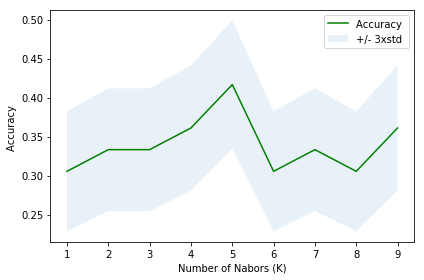

In [104]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [105]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 
neigh_2 = KNeighborsClassifier(n_neighbors = 2).fit(train_x,train_y)

The best accuracy was with 0.4166666666666667 with k= 5


## Decision Tree

In [106]:
from sklearn.tree import DecisionTreeClassifier

In [107]:
dTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
dTree.fit(train_x,train_y)
predTree_D = dTree.predict(test_x)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(test_y, predTree_D))

DecisionTrees's Accuracy:  0.3055555555555556


In [109]:
neigh_2.predict(data_to_predict)

array([2, 2, 4, 2, 3, 1, 1, 2, 3, 2, 1, 4, 2, 1, 1, 3, 2, 1, 1, 2, 2, 2,
       2, 1, 3, 1, 1, 2, 1, 1, 1, 1, 4, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2,
       2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 3, 1, 1], dtype=int64)

In [110]:
dTree.predict(data_to_predict)

array([5, 2, 3, 2, 2, 2, 2, 2, 5, 2, 2, 5, 5, 2, 2, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 5, 5, 2, 2, 2, 2, 2, 2, 4, 2, 5, 2, 5, 2, 2, 5, 2, 2, 2, 2,
       2, 2, 2, 2, 5, 2, 5, 2, 2, 2, 2, 4, 2, 2], dtype=int64)

나의 평점을 좀 더 범위를 넓혀서, 좀 더 패턴이 있게 측정을 해보면 어떨까 

In [114]:
restaurant_Yeoksam = df_for_ML_copy.loc[df_for_ML_copy.Station == 'Yeoksam',]
restaurant_Yeoksam

,name,categories,lat,lng,id,Station,New_categories,distance,price,rating,photos_count,tips_count,BBQ Joint,Buffet,Burger Joint,Chinese Restaurant,Japanese Restaurant,Korean Restaurant,Pizza Place,Seafood Restaurant,South&SE Asian Restaurant,Western Restaurant
0,고갯마루집,Korean Restaurant,37.499361,127.039308,4d12cb2a12916dcb3d1fd98a,Yeoksam,Korean Restaurant,0.009911,2.0,8.4,69,16,0,0,0,0,0,1,0,0,0,0
1,Yang Good (양국),BBQ Joint,37.502146,127.034727,5703972bcd107356d0a6cee9,Yeoksam,BBQ Joint,0.010252,2.0,8.3,134,20,1,0,0,0,0,0,0,0,0,0
2,불이아 (弗二我),Chinese Restaurant,37.502396,127.036219,52aa9d0111d25f79bea32b9d,Yeoksam,Chinese Restaurant,0.010907,1.0,8.0,84,13,0,0,0,1,0,0,0,0,0,0
3,대우식당,Korean Restaurant,37.502750,127.035137,4b8a4a0ef964a520246732e3,Yeoksam,Korean Restaurant,0.010933,2.0,8.2,169,26,0,0,0,0,0,1,0,0,0,0
4,BAS BURGER (바스버거),Burger Joint,37.499723,127.035882,57c65f00498ed5b609eaf4ef,Yeoksam,Burger Joint,0.008299,1.0,8.0,30,7,0,0,1,0,0,0,0,0,0,0
5,이도곰탕,Korean Restaurant,37.503173,127.038387,4e55bba41495b62c8a10ebb6,Yeoksam,Korean Restaurant,0.012499,2.0,8.1,275,29,0,0,0,0,0,1,0,0,0,0
6,랭돈,BBQ Joint,37.501669,127.034903,5a8aa9ac6dcf044534b4d857,Yeoksam,BBQ Joint,0.009828,2.0,7.7,104,4,1,0,0,0,0,0,0,0,0,0
7,오발탄,Korean Restaurant,37.499504,127.038437,4b73e454f964a52010bf2de3,Yeoksam,Korean Restaurant,0.009448,2.0,7.7,121,5,0,0,0,0,0,1,0,0,0,0
8,베이징코야,Chinese Restaurant,37.499818,127.039075,4d6b7466d2596ea87f8f7120,Yeoksam,Chinese Restaurant,0.010096,1.0,7.6,97,16,0,0,0,1,0,0,0,0,0,0
9,Long Bread (롱브레드),Sandwich Place,37.498996,127.035325,4cc7980cfa03224b9da03fef,Yeoksam,Western Restaurant,0.007412,1.0,7.6,142,23,0,0,0,0,0,0,0,0,0,1


In [122]:
restaurant_Yeoksam['KNN_rating'] = pd.Series(neigh_2.predict(data_to_predict))

C:\Users\minda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [126]:
column_filter= ['name','lat','lng','New_categories','KNN_rating']
restaurant_Yeoksam = restaurant_Yeoksam.loc[:,column_filter]

In [128]:
restaurant_Yeoksam.head()

,name,lat,lng,New_categories,KNN_rating
0,고갯마루집,37.499361,127.039308,Korean Restaurant,2
1,Yang Good (양국),37.502146,127.034727,BBQ Joint,2
2,불이아 (弗二我),37.502396,127.036219,Chinese Restaurant,4
3,대우식당,37.502750,127.035137,Korean Restaurant,2
4,BAS BURGER (바스버거),37.499723,127.035882,Burger Joint,3


In [143]:
rating_3 = restaurant_Yeoksam.loc[restaurant_Yeoksam.KNN_rating >= 2,]

In [144]:
map_gangnam = folium.Map(location=[office_lat, office_lng], zoom_start=15)

for lat, lng, borough, neighborhood in zip(rating_3['lat'], rating_3['lng'], rating_3['name'], rating_3['New_categories']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_gangnam) 

    
folium.CircleMarker(
        [office_lat, office_lng],
        radius=6,
        popup='office',
        color='red',
        fill=False,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_gangnam) 


map_gangnam